In [2]:
# %pip install torch
# %pip install torch_geometric
# %pip install networkx

In [3]:
from scipy.io import mmread
import pandas as pd
from scipy import sparse
from torch_geometric.data import Data
import networkx as nx
import torch

In [ ]:
rawData = mmread('scRNA.mtx')
coo_matrix = rawData.tocoo()

pd_data = pd.DataFrame({
    "gene": coo_matrix.row,
    "cell": coo_matrix.col,
    "expression": coo_matrix.data
})

print(pd_data['expression'].describe())

count    8.642244e+07
mean     3.145017e+02
std      1.474521e+03
min      3.754523e-02
25%      4.758733e+01
50%      9.236428e+01
75%      2.114828e+02
max      9.125702e+05
Name: expression, dtype: float64


In [5]:
def filterData(data): 
    threshold_lower = 80000
    data_filtered = data[data['expression'] > threshold_lower] 

    return data_filtered

def convertToSparseMatrixCOO(data):
    cell = data['cell']
    gene = data['gene']
    expression = data['expression']

    coo_matrix = sparse.coo_matrix((expression, (cell, gene)), dtype='float64')
    return coo_matrix

filtred_data = filterData(pd_data)
converted_data = convertToSparseMatrixCOO(filtred_data)
print(filtred_data)

           gene   cell  expression
283697    17096     81   99604.250
284331    17096     82  106040.600
395840    17096    117  112160.500
507749    17096    145  128562.520
601163    17096    181   80766.540
...         ...    ...         ...
86389399  24531  27163   90961.086
86393126  24531  27165   80971.110
86398624  24531  27167   89592.860
86412018  24531  27174  109349.640
86422299  24531  27179   95590.130

[2983 rows x 3 columns]


In [6]:
cell_gene_matrix = filtred_data.pivot(index='cell', columns='gene', values='expression').fillna(0)
print("Cell-Gene Matrix:")
print(cell_gene_matrix)

Cell-Gene Matrix:
gene   1677   2574   3676   4688   7466   8058   9587   10442  10776  11647  \
cell                                                                          
81       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
82       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
117      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
145      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
181      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
27163    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
27165    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
27167    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
27174    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
27179    0.0    0.0    0.0    0.0 

In [7]:
# Convert DataFrame to Tensor
tensor_data = torch.tensor(cell_gene_matrix.values, dtype=torch.float32)
print("Tensor Data:")
print(tensor_data)

Tensor Data:
tensor([[     0.0000,      0.0000,      0.0000,  ...,      0.0000,
              0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,  ...,      0.0000,
              0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,  ...,      0.0000,
              0.0000,      0.0000],
        ...,
        [     0.0000,      0.0000,      0.0000,  ...,      0.0000,
          89592.8594,      0.0000],
        [     0.0000,      0.0000,      0.0000,  ...,      0.0000,
         109349.6406,      0.0000],
        [     0.0000,      0.0000,      0.0000,  ...,      0.0000,
          95590.1328,      0.0000]])


In [8]:
from torch.nn.functional import cosine_similarity

def batched_cosine_similarity(data, batch_size=1000):
    similarities = []
    for i in range(0, data.size(0), batch_size):
        batch = data[i:i + batch_size]
        sim = cosine_similarity(batch.unsqueeze(1), data.unsqueeze(0), dim=2)
        similarities.append(sim)
    return torch.cat(similarities)

# Compute similarity in batches
similarity_matrix = batched_cosine_similarity(tensor_data, batch_size=100)
print(similarity_matrix)

G = nx.Graph()


cells = list(cell_gene_matrix.index)
G.add_nodes_from(cells)

threshold = 0.9
for i in range(len(cells)):
    for j in range(i + 1, len(cells)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(cells[i], cells[j], weight=float(similarity_matrix[i, j]))


tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])


In [13]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


edges = list(G.edges(data=True))  
edge_index = torch.tensor([[edge[0], edge[1]] for edge in edges], dtype=torch.long).t()


edge_weights = torch.tensor([edge[2]["weight"] for edge in edges], dtype=torch.float)


node_features = torch.tensor(cell_gene_matrix.values, dtype=torch.float)


mapping = {node: i for i, node in enumerate(G.nodes())}


edge_index = torch.tensor([[mapping[edge[0]], mapping[edge[1]]] for edge in edges], dtype=torch.long).t()



ordered_nodes = [node for node in G.nodes()]
node_features = torch.tensor(cell_gene_matrix.loc[ordered_nodes].values, dtype=torch.float)


graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weights)


print("PyTorch Geometric Data Object:")
print(graph_data)

Number of nodes: 2675
Number of edges: 1765327
PyTorch Geometric Data Object:
Data(x=[2675, 22], edge_index=[2, 1765327], edge_attr=[1765327])


In [14]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        
        self.conv1 = SAGEConv(in_channels, hidden_channels)
      
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
       
        x = self.conv1(x, edge_index)
        x = F.relu(x)
   
        x = self.conv2(x, edge_index)
        return x

In [ ]:
x = graph_data.x  
edge_index = graph_data.edge_index 

In [ ]:
model = GraphSAGE(in_channels=x.size(1), hidden_channels=32, out_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x, edge_index = x.to(device), edge_index.to(device)


for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    

    node_embeddings = model(x, edge_index)
    
    loss = torch.mean(torch.norm(node_embeddings, dim=1))  # Dummy loss
    
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 51545.69140625
Epoch 10, Loss: 7964.11572265625
Epoch 20, Loss: 2929.4609375
Epoch 30, Loss: 1202.0350341796875
Epoch 40, Loss: 764.1469116210938
Epoch 50, Loss: 660.765625
Epoch 60, Loss: 349.624755859375
Epoch 70, Loss: 786.30712890625
Epoch 80, Loss: 333.4604797363281
Epoch 90, Loss: 370.3026428222656


In [1]:
from sklearn.cluster import KMeans


embeddings = node_embeddings.detach().cpu().numpy()
print(embeddings)

kmeans = KMeans(n_clusters=5, random_state=42).fit(embeddings)


labels = kmeans.labels_
print("Cluster Labels:", labels)

NameError: name 'node_embeddings' is not defined

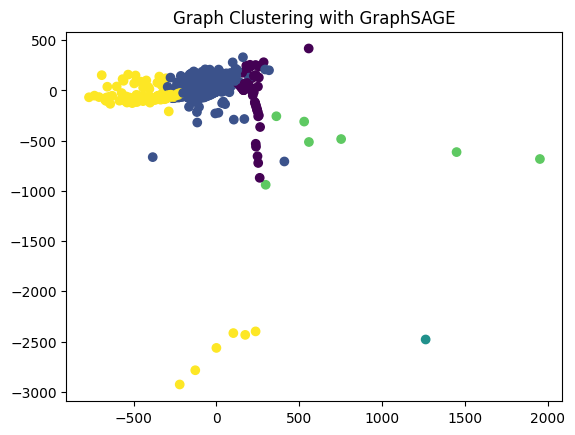

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis')
plt.title("Graph Clustering with GraphSAGE")
plt.show()

In [ ]:

model.eval()

with torch.no_grad():
    node_embeddings = model(graph_data.x, graph_data.edge_index)

print("Node Embeddings Shape:", node_embeddings.shape)

Node Embeddings Shape: torch.Size([2675, 16])


In [ ]:
from sklearn.cluster import KMeans


num_clusters = 5  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)


clusters = kmeans.fit_predict(node_embeddings.cpu().numpy())

print("Cluster Assignments:", clusters)

Cluster Assignments: [0 0 0 ... 1 1 1]


In [ ]:
from sklearn.metrics import silhouette_score


sil_score = silhouette_score(node_embeddings.cpu().numpy(), clusters)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.45487213
